In [ ]:
!pip install stable-baselines==2.9.0

In [2]:
import datetime
from time import time

import numpy as np

import torch as T
from torch.autograd import Variable
import torch.nn as nn
from torch.distributions import Categorical
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR

from stable_baselines.common.misc_util import set_global_seeds
from stable_baselines.common.cmd_util import make_atari_env
from stable_baselines.common.vec_env import VecFrameStack, VecNormalize
from stable_baselines.common.running_mean_std import RunningMeanStd

from google.colab import drive
from itertools import count

In [ ]:
ENV_NAME = 'SpaceInvadersNoFrameskip-v4'
SAVE_PATH = '/content/gdrive/My Drive/Colab Notebooks/A2C/'

TOTAL_FRAMES = 5e6  # 5 million frames
ROLLOUT_LENGTH = 5  # transitions in each rollout
NENV = 8            # parallel environments, increase to decorrolate batches
GAMMA = 0.99        # reward discounting coefficient
SEED = 420          # blaze it
STEPS_PER_ROLLOUT = ROLLOUT_LENGTH*NENV
TOTAL_UPDATES = int(TOTAL_FRAMES // STEPS_PER_ROLLOUT)
DEVICE = T.device('cuda' if T.cuda.is_available() else 'cpu')

set_global_seeds(SEED)

In [ ]:
drive.mount('/content/gdrive')

In [4]:
class Logger:

    def __init__(self, print_rate=250):
        self.log = {'ep_r':[], 'ep_l':[], 'loss':[], 'pgloss':[], 
                    'vloss':[], 'ent':[]}
        self.n_ep = 0              # total games/episodes
        self.n_update = 1          # total weight updates
        self.n_frames = 0          # env steps (total from checkpoint)
        self.run_frames = 0        # env steps (for this run)
        self.max_rwd = -np.inf     # max rwd out of all games played
        self.start_time = time()   # time we started *this* run
        self.last_checkpoint = 0   # total_frames at last checkpoint
        self.print_rate = print_rate

    def eta(self):  # get hh:mm:ss left to train
        elapsed_time = time() - self.start_time
        frames_left = TOTAL_FRAMES - self.n_frames
        sec_per_frame = elapsed_time / self.n_frames
        sec_left = int(frames_left * sec_per_frame)
        eta_str = str(datetime.timedelta(seconds=sec_left))
        return eta_str

    def fps(self):  # get frames per second
        elapsed_time = time() - self.start_time
        fps = int(self.run_frames / elapsed_time)
        return fps

    def sma(self, x):  # simple moving average
        div = 200 if len(x) > 200 else len(x)
        return sum(list(zip(*x[-div:]))[-1])/div

    def print_log(self):
        fps = self.fps()
        eta = self.eta()
        print('-'*10, self.n_update, '/', TOTAL_UPDATES, '-'*10)
        print('Num Games:', self.n_ep)
        print('Num Frames:', self.n_frames)
        print('FPS:', fps)
        print('ETA:', eta)
        print('SMA Length:', self.sma(self.log['ep_l']))
        print('SMA Reward:', self.sma(self.log['ep_r']))
        print('SMA Entropy:', self.sma(self.log['ent']))
        print('SMA Loss:', self.sma(self.log['loss']))
        print('SMA PG Loss:', self.sma(self.log['pgloss']))
        print('SMA V Loss:', self.sma(self.log['vloss']))
        print('Max reward:', self.max_rwd)

    def record(self, ep, loss, pgloss, vloss, ent):
        
        self.n_update += 1
        self.n_frames += STEPS_PER_ROLLOUT
        self.run_frames += STEPS_PER_ROLLOUT
        fr = (self.n_frames, self.n_update)

        # stats about finished episodes/games
        for l, r in zip(ep['l'], ep['r']):
            self.log['ep_l'].append(fr+(l,))
            self.log['ep_r'].append(fr+(r,))
            if r > self.max_rwd: self.max_rwd = r
            self.n_ep += 1
             
        # nn training statistics
        self.log['loss'].append(fr+(loss,))
        self.log['pgloss'].append(fr+(pgloss,))
        self.log['vloss'].append(fr+(vloss,))
        self.log['ent'].append(fr+(ent,))
        
        # print log
        if self.n_update % self.print_rate == 0:
            self.print_log()

In [5]:
class AC(nn.Module):
  
    def __init__(self, input_shape, num_actions):
        super().__init__()
        h, w, c = input_shape

        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, 8, 4),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2),
            nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 1),
            nn.ReLU(True),
        )
        
        f = self.conv_size(self.conv, (c,h,w))

        self.flat = nn.Sequential(
            nn.Flatten(),
            nn.Linear(f, 512),
            nn.ReLU(True)
        )

        self.backbone = nn.Sequential(self.conv, self.flat)
        self.actor = nn.Linear(512, num_actions)
        self.critic = nn.Linear(512, 1)

    def conv_size(self, net, in_shape):
        x = Variable(T.rand(1, *in_shape))
        o = net(x)
        b = (-1, o.size(1), o.size(2), o.size(3))
        return o.data.view(1, -1).size(1)

    def forward(self, x):
        latent = self.backbone(x)
        return self.actor(latent), self.critic(latent)

In [6]:
def ob_to_torch(x):
    x = np.moveaxis(x, -1, 1)
    x = T.from_numpy(x).float()
    x = x.to(DEVICE)
    return x

def rollout_generator(env, policy):

    ob = ob_to_torch(env.reset())
    mb = {'obs':[], 'act':[], 'rwd':[], 'done':[], 'val':[]}
    ep = {'l':[], 'r':[]}  # len & total reward of done eps 
    
    for step in count(1):

        # we compute gradients in the train loop
        with T.no_grad():
            logits, val = policy(ob)
            dist = Categorical(logits=logits)
            action = dist.sample()
        
        new_ob, rwd, done, info = env.step(action)
        
        # store transition
        mb['obs'].append(ob)
        mb['act'].append(action)
        mb['rwd'].append(T.from_numpy(rwd))
        mb['val'].append(val.view(-1))
        mb['done'].append(T.from_numpy(done))
        for t in info:
            if t.get('episode'):
                ep['l'].append(t['episode']['l'])
                ep['r'].append(t['episode']['r'])

        ob = ob_to_torch(new_ob)

        if step % ROLLOUT_LENGTH != 0:
            continue

        ########################################################
        ###         Flatten rollout & assign credit          ###
        ########################################################
        ### Credit is bootstrapped from our critic (value    ###
        ### function) if the episode is not terminal. This   ###
        ### bootstrapped credit comes from the estimated     ###
        ### value of the *next* state, making it TD(0).      ###
        ########################################################

        for k in mb.keys():
            mb[k] = T.stack(mb[k]).to(DEVICE)

        # bootstrap from value function - TD(0)
        with T.no_grad():
            last_val = policy(ob)[1].view(-1) * ~mb['done'][-1]
            mb['rwd'][-1] += GAMMA * last_val

        # discount (bootstrapped) rewards
        for i in reversed(range(ROLLOUT_LENGTH-1)):
            mb['rwd'][i] += GAMMA * mb['rwd'][i+1] * ~mb['done'][i]

        # flatten to (NENV*ROLLOUT_LENGTH, ...)
        for k in mb.keys():
            s = mb[k].size()
            mb[k] = mb[k].view(STEPS_PER_ROLLOUT, *s[2:])
        
        yield mb, ep
        mb = {'obs':[], 'act':[], 'rwd':[], 'done':[], 'val':[]}
        ep = {'l':[], 'r':[]}

In [0]:
def save_checkpoint(checkpoint_id):
    checkpoint = {
        'env': env,
        'ac': ac.state_dict(),
        'ac_opt': ac_optimizer.state_dict(),
        'logger': logger
    }
    X = str(checkpoint_id)
    T.save(checkpoint, SAVE_PATH+X+'.'+ENV_NAME+'.checkpoint')

In [0]:
def load_checkpoint(file_name):
    checkpoint = T.load(file_name)
    
    venv = make_atari_env(ENV_NAME, num_env=NENV, seed=SEED)
    venv = VecFrameStack(venv, n_stack=4)
    env = checkpoint['env']
    env.set_venv(venv)
    in_dim = env.observation_space.shape
    policy_dim = env.action_space.n

    ac = AC(in_dim, policy_dim).to(DEVICE)
    ac.load_state_dict(checkpoint['ac'])
    ac_optimizer = Adam(ac.parameters(), 7e-4, eps=1e-5)
    ac_optimizer.load_state_dict(checkpoint['ac_opt'])

    logger = checkpoint['logger']

    return env, ac, ac_optimizer, logger

In [0]:
def new_run():

    # setup parallelised gym environments (MaxAndSkip=4 by default)
    env = make_atari_env(ENV_NAME, num_env=NENV, seed=SEED)
    env._max_episode_steps = 4500*4
    env = VecFrameStack(env, n_stack=4)
    env = VecNormalize(env, norm_reward=False, clip_reward=1e5, gamma=1.0)
    in_dim = env.observation_space.shape
    policy_dim = env.action_space.n

    # get actor + critic
    ac = AC(in_dim, policy_dim).to(DEVICE)
    ac_optimizer = Adam(ac.parameters(), 7e-4, eps=1e-5)

    logger = Logger()

    return env, ac, ac_optimizer, logger

In [0]:
env, ac, ac_optimizer, logger = new_run()
# env, ac, ac_optimizer, logger = load_checkpoint(SAVE_PATH+'FINAL.SpaceInvadersNoFrameskip-v4.checkpoint')

In [12]:
rollouts = rollout_generator(env, ac)
scheduler = LambdaLR(ac_optimizer, lambda i: 1 - i / TOTAL_UPDATES)

for i_update in range(logger.n_update, TOTAL_UPDATES):

    mb, ep = next(rollouts)

    # calculate advantange
    logits, val = ac(mb['obs'])
    dist = Categorical(logits=logits)
    ent = dist.entropy().mean()
    logp = dist.log_prob(mb['act'])
    adv = mb['rwd'] - mb['val']
    
    # calculate losses (soft ac with entropy)
    vloss = (val.view(-1) - mb['rwd']).pow(2).mean()
    pgloss = -(adv * logp).mean()
    loss = pgloss + 0.5*vloss - 0.01*ent
    
    # update policy
    ac_optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(ac.parameters(), 0.5)
    ac_optimizer.step()
    scheduler.step(i_update)

    logger.record(ep, loss.item(), pgloss.item(), vloss.item(), ent.item())
    
    # make a checkpoint every 1m frames
    if logger.n_frames - logger.last_checkpoint > 1e6:
        save_checkpoint(logger.n_frames)
        logger.last_checkpoint = logger.n_frames

save_checkpoint('FINAL')

Streaming output truncated to the last 5000 lines.
SMA Length: 616.75
SMA Reward: 263.3
SMA Entropy: 1.4353362840414048
SMA Loss: 0.03395372453145683
SMA PG Loss: 0.005755833614966832
SMA V Loss: 0.08510250709950924
Max reward: 1000.0
---------- 21250 / 125000 ----------
Num Games: 1536
Num Frames: 849960
FPS: 348
ETA: 3:18:30
SMA Length: 617.185
SMA Reward: 259.35
SMA Entropy: 1.380109850168228
SMA Loss: 0.03654644693247974
SMA PG Loss: 0.010201071850315203
SMA V Loss: 0.08029294669162482
Max reward: 1000.0
---------- 21500 / 125000 ----------
Num Games: 1554
Num Frames: 859960
FPS: 348
ETA: 3:17:56
SMA Length: 620.67
SMA Reward: 256.4
SMA Entropy: 1.6018554019927977
SMA Loss: 0.03928112387191504
SMA PG Loss: 0.018606905368505976
SMA V Loss: 0.07338554495712742
Max reward: 1000.0
---------- 21750 / 125000 ----------
Num Games: 1570
Num Frames: 869960
FPS: 348
ETA: 3:17:24
SMA Length: 617.77
SMA Reward: 254.25
SMA Entropy: 1.4429577332735062
SMA Loss: 0.04183588407468051
SMA PG Loss: 0

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()

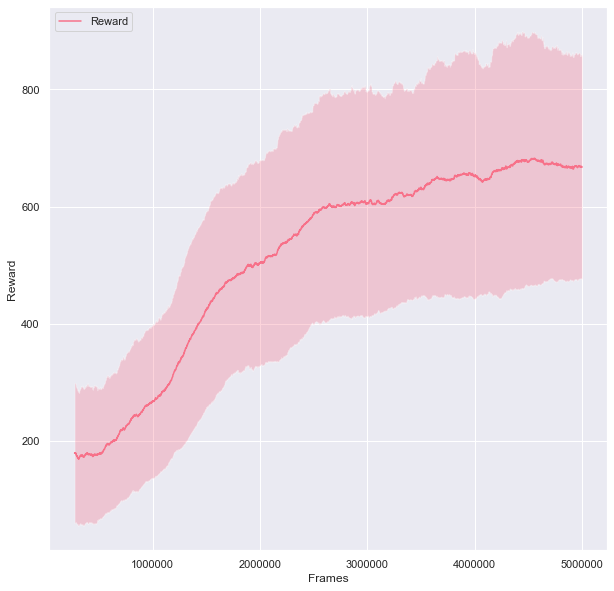

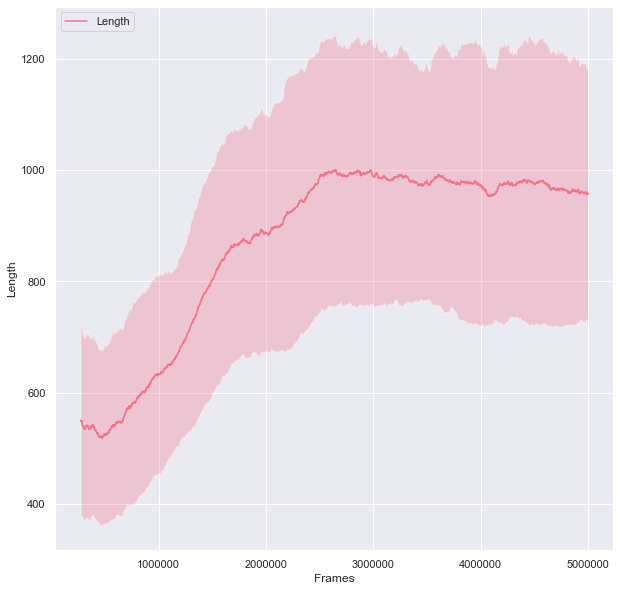

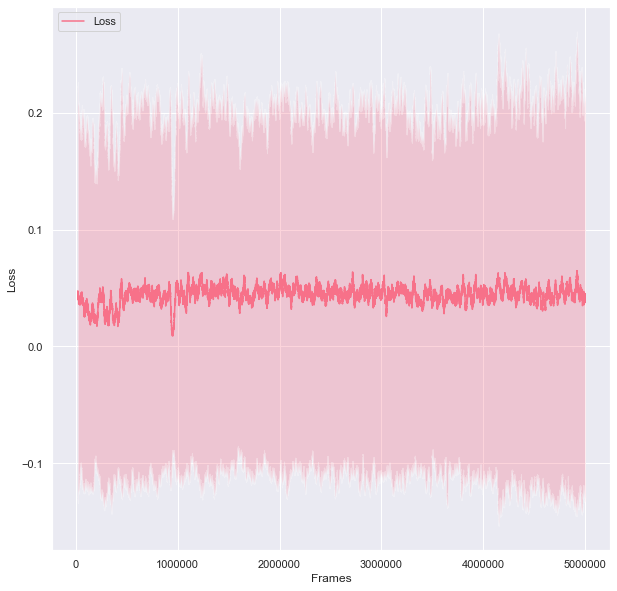

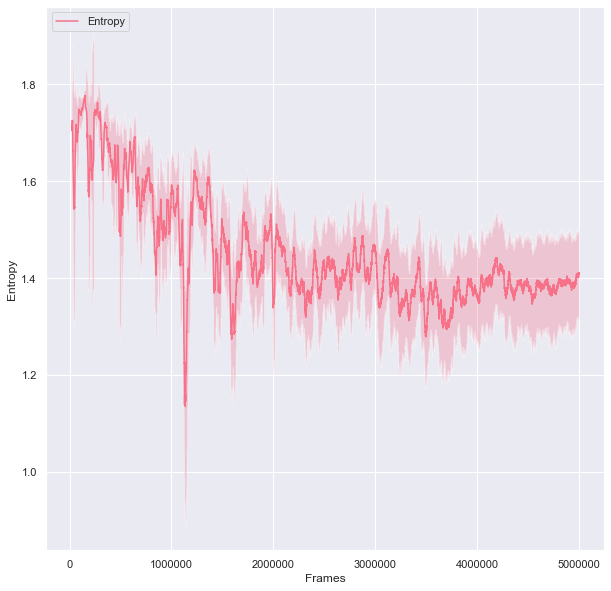

In [9]:
def plot_log(log, ylabel):
    # compute rolling avg and std
    df = pd.DataFrame(log, columns =['Frames', 'Iters', ylabel])
    sma_y = df[ylabel].rolling(500).mean()
    std_y = df[ylabel].rolling(500).std()
    
    # plot with seaborn
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xlabel('Frames')
    ax.set_ylabel(ylabel)
    clrs = sns.color_palette("husl", 8)

    # fill standard deviation
    ax.plot(df['Frames'], sma_y, label=ylabel, c=clrs[0])
    ax.fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                    alpha=0.3, facecolor=clrs[0]) 
    ax.legend(loc='upper left')
    plt.savefig(ENV_NAME+'.'+ylabel+'.plt.png', 
                dpi=300, pad_inches=0)
    plt.show()

plot_log(logger.log['ep_r'], 'Reward')
plot_log(logger.log['ep_l'], 'Length')
plot_log(logger.log['loss'], 'Loss')
plot_log(logger.log['ent'], 'Entropy')

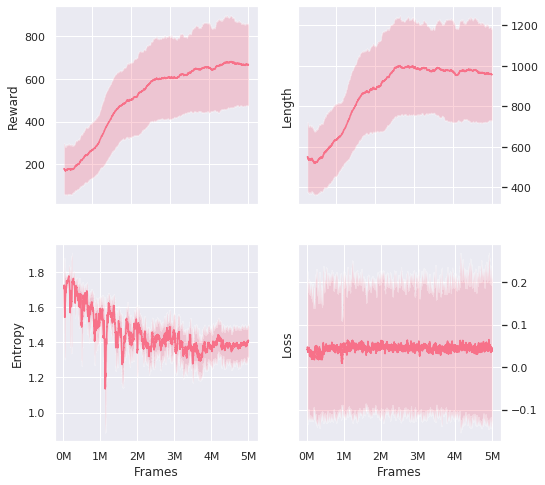

In [14]:
fig_all, ax_all = plt.subplots(2,2, figsize=(8,8))

## REWARD 
df = pd.DataFrame(logger.log['ep_r'], columns =['Frames', 'Iters', 'rwd'])
sma_y = df['rwd'].rolling(500).mean()
std_y = df['rwd'].rolling(500).std()

ax_all[0][0].set_ylabel('Reward')
clrs = sns.color_palette("husl", 8)

# fill standard deviation
ax_all[0][0].plot(df['Frames'], sma_y, label='Episode Reward', c=clrs[0])
ax_all[0][0].fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                alpha=0.3, facecolor=clrs[0])

# make x axis nice
ax_all[0][0].set_xticklabels('')


## LENGTH 
df = pd.DataFrame(logger.log['ep_l'], columns =['Frames', 'Iters', 'Len'])
sma_y = df['Len'].rolling(500).mean()
std_y = df['Len'].rolling(500).std()

ax_all[0][1].set_ylabel('Length')
ax_all[0][1].yaxis.tick_right()
clrs = sns.color_palette("husl", 8)

# fill standard deviation
ax_all[0][1].plot(df['Frames'], sma_y, label='Episode Length', c=clrs[0])
ax_all[0][1].fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                alpha=0.3, facecolor=clrs[0])

# make x axis nice
ax_all[0][1].set_xticklabels('')


## ENTROPY 
df = pd.DataFrame(logger.log['ent'], columns =['Frames', 'Iters', 'ent'])
sma_y = df['ent'].rolling(500).mean()
std_y = df['ent'].rolling(500).std()

ax_all[1][0].set_xlabel('Frames')
ax_all[1][0].set_ylabel('Entropy')
clrs = sns.color_palette("husl", 8)

# fill standard deviation
ax_all[1][0].plot(df['Frames'], sma_y, label='Entropy', c=clrs[0])
ax_all[1][0].fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                alpha=0.3, facecolor=clrs[0])

# make x axis nice
xlabels = [f'{int(x)}M' for x in ax_all[1][0].get_xticks()/1e6]
ax_all[1][0].set_xticklabels(xlabels)


## LOSS 
df = pd.DataFrame(logger.log['loss'], columns =['Frames', 'Iters', 'Loss'])
sma_y = df['Loss'].rolling(500).mean()
std_y = df['Loss'].rolling(500).std()

ax_all[1][1].set_xlabel('Frames')
ax_all[1][1].set_ylabel('Loss')
ax_all[1][1].yaxis.tick_right()
clrs = sns.color_palette("husl", 8)

# fill standard deviation
ax_all[1][1].plot(df['Frames'], sma_y, label='Loss', c=clrs[0])
ax_all[1][1].fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                alpha=0.3, facecolor=clrs[0])

# make x axis nice
xlabels = [f'{int(x)}M' for x in ax_all[1][1].get_xticks()/1e6]
ax_all[1][1].set_xticklabels(xlabels)

plt.savefig(SAVE_PATH+ENV_NAME+'_plot_thesis.png', 
            dpi=300, pad_inches=0, bbox_inches = 'tight')

plt.show()

# Save log for comparisons

In [8]:
import pickle
log = T.load('FINAL.'+ENV_NAME+'.checkpoint', map_location=T.device('cpu'))['logger'].log
pickle.dump(log, open('FINAL.'+ENV_NAME+'.log', 'wb'))